In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q tensorflow seaborn scikit-learn tqdm

Mounted at /content/drive


In [6]:
import os, shutil, hashlib, pickle, gzip, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2S
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)



In [7]:
DATA_DIR = '/content/drive/MyDrive/Tree_Species_Dataset'
print(os.listdir(DATA_DIR)[:10])
BATCH = 32
IMG_SIZE = 224
SEED = 42


['Indian_Gooseberry', 'Silk_Cotton_Tree', 'Bamboo', 'White_Cheesewood', 'Royal_Poinciana', 'Other', 'Indian_Elm', 'Banyan', 'Cactus', 'Acacia']


In [8]:
# @title Data Cleaning
import os
import shutil
import hashlib
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# Remove .git if present
git_path = os.path.join(DATA_DIR, '.git')
if os.path.isdir(git_path):
    shutil.rmtree(git_path)

def md5_hash(path):
    """Returns MD5 hash of a file"""
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def is_image(fname):
    """Check if file has a valid image extension"""
    return fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))

def clean_dataset(root_dir, min_size=50):
    seen = set()
    removed, total = 0, 0

    for root, _, files in os.walk(root_dir):
        for fname in tqdm(files, desc="Cleaning"):
            total += 1
            path = os.path.join(root, fname)

            if not is_image(fname):
                continue

            try:
                with Image.open(path) as img:
                    img.verify()
                    img = Image.open(path).convert('RGB')
                    if min(img.size) < min_size:
                        os.remove(path)
                        removed += 1
                        continue

                h = md5_hash(path)
                if h in seen:
                    os.remove(path)
                    removed += 1
                else:
                    seen.add(h)

            except (UnidentifiedImageError, OSError):
                os.remove(path)
                removed += 1

    print(f"Total files scanned: {total}")
    print(f"Total files removed: {removed}")
clean_dataset(DATA_DIR)

Cleaning: 0it [00:00, ?it/s]
Cleaning: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]

Total files scanned: 1514
Total files removed: 0


In [10]:
english_names = {
    'vad'        : 'Banyan',
    'saptaparni' : 'White Cheesewood',
    'sugarcane'  : 'Sugarcane',
    'pilikaren'  : 'Indian Elm',
    'shirish'    : 'Rain Tree',
    'sonmahor'   : 'Golden Shower Tree',
    'pipal'      : 'Sacred Fig',
    'simlo'      : 'Silk Cotton Tree',
    'other'      : 'Other',
    'sitafal'    : 'Custard Apple',
    'motichanoti': 'Coral Jasmine',
    'gunda'      : 'Glue Berry',
    'gulmohor'   : 'Royal Poinciana',
    'jamun'      : 'Java Plum',
    'kesudo'     : 'Flame of the Forest',
    'kanchan'    : 'Mountain Ebony',
    'mango'      : 'Mango',
    'nilgiri'    : 'Eucalyptus',
    'khajur'     : 'Date Palm',
    'neem'       : 'Neem',
    'bamboo'     : 'Bamboo',
    'coconut'    : 'Coconut Palm',
    'garmalo'    : 'Indian Laburnum',
    'cactus'     : 'Cactus',
    'champa'     : 'Plumeria',
    'asopalav'   : 'Ashoka Tree',
    'amla'       : 'Indian Gooseberry',
    'banyan'     : 'Banyan',
    'babul'      : 'Acacia',
    'bili'       : 'Bael Tree'
}


In [11]:
# @title Data Augmentation  And Genrator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



# Rename folders to English
for old in os.listdir(DATA_DIR):
    old_path = os.path.join(DATA_DIR, old)
    if os.path.isdir(old_path) and old in english_names:
        new = english_names[old].replace(' ', '_')
        new_path = os.path.join(DATA_DIR, new)
        if old_path != new_path:
            shutil.move(old_path, new_path)

# Data Augmentation
aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

aug_finetune = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=45,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=20,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

#  Generators
train_gen = aug.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    seed=SEED
)

val_gen = aug.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False,
    seed=SEED
)

train_gen_ft = aug_finetune.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

#  Class Weights
y_int = train_gen.labels
class_weights = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
))

#  Human-readable class names
class_names = list(train_gen.class_indices.keys())
readable = [english_names.get(name.replace('_', ' '), name) for name in class_names]
print("Readable class names:", readable)

Found 1220 images belonging to 29 classes.
Found 294 images belonging to 29 classes.
Found 1220 images belonging to 29 classes.
Readable class names: ['Acacia', 'Ashoka_Tree', 'Bael_Tree', 'Bamboo', 'Banyan', 'Cactus', 'Coconut_Palm', 'Coral_Jasmine', 'Custard_Apple', 'Date_Palm', 'Eucalyptus', 'Flame_of_the_Forest', 'Glue_Berry', 'Golden_Shower_Tree', 'Indian_Elm', 'Indian_Gooseberry', 'Indian_Laburnum', 'Java_Plum', 'Mango', 'Mountain_Ebony', 'Neem', 'Other', 'Plumeria', 'Rain_Tree', 'Royal_Poinciana', 'Sacred_Fig', 'Silk_Cotton_Tree', 'Sugarcane', 'White_Cheesewood']


In [12]:
y_int = train_gen.labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_int),
    y=y_int
)
class_weights = dict(enumerate(class_weights))


In [13]:
# @title Basic CNN
def build_basic_cnn(num_classes, input_shape=(224,224,3)):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


In [ ]:
# @title Basic CNN Model (Already Trained)
num_classes = 29
basic_cnn = build_basic_cnn(num_classes)
basic_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/basic_cnn_base.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history_basic = basic_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)



In [33]:
# @title Model Evaluation for Basic CNN

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def evaluate_model_basic(model_path, model_name, readable_labels, validation_genrator):
    print(f"\n{'-'*40} Evaluating Model: {model_name} {'-'*40}")

    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Evaluate on validation data
    val_loss, val_acc = model.evaluate(validation_genrator, verbose=0)

    # Predictions
    y_pred_probs = model.predict(validation_genrator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = validation_genrator.classes

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n{'-'*35} Evaluation Metrics {'-'*35}")
    print(f"🔸Validation Loss     : {val_loss:.4f}")
    print(f"🔸Validation Accuracy : {val_acc:.4f}")
    print(f"🔹Accuracy            : {acc:.4f}")
    print(f"🔹Macro F1            : {macro_f1:.4f}")
    print(f"🔹Weighted F1         : {weighted_f1:.4f}")
    print(f"🔹Macro Precision     : {macro_precision:.4f}")
    print(f"🔹Macro Recall        : {macro_recall:.4f}")

    print(f"\n{'-'*33} Classification Report {'-'*33}")
    print(classification_report(y_true, y_pred, target_names=readable_labels, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=readable_labels, yticklabels=readable_labels, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        "name": model_name,
        "model": model,
        "path": model_path,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall
    }


In [15]:
# @title Mobnet Base

def build_mobilenetv2(num_classes, input_shape=(224,224,3), dropout_rate=0.4):
    base = tf.keras.applications.MobileNetV2(
        weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [66]:
# @title Model Evaluation For mob net

from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class TopKAccFloat32(TopKCategoricalAccuracy):
    def __init__(self, k=3, name='top_3_acc', dtype='float32', **kwargs):
        super().__init__(k=k, name=name, dtype=dtype, **kwargs)

def evaluate_model(model_path, model_name, validation_generator, readable_labels):
    print("=" * 100)
    print(f"{model_name:^100}")
    print("=" * 100)

    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from tensorflow.keras.models import load_model
    from sklearn.metrics import (
        classification_report, confusion_matrix,
        accuracy_score, f1_score, precision_score, recall_score
    )

    # Load the model
    model = load_model(model_path, custom_objects={'TopKAccFloat32': TopKAccFloat32})

    # Evaluate on validation set
    eval_results = model.evaluate(validation_generator, verbose=0)
    metric_names = model.metrics_names

    print("\n Evaluation Metrics:")
    for name, val in zip(metric_names, eval_results):
        print(f"  🔹 {name:<20}: {val:.4f}")

    # Predictions
    y_true, y_pred = [], []
    for images, labels in validation_generator:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        if len(y_true) >= validation_generator.samples:
            break

    y_true = np.array(y_true[:validation_generator.samples])
    y_pred = np.array(y_pred[:validation_generator.samples])

    # Classification report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=readable_labels))

    # Key Summary Metrics
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')

    print("\n Summary Metrics:")
    print(f"🔹 Accuracy        : {acc:.2f} ")
    print(f"🔹 Macro F1        : {macro_f1:.2f} ")
    print(f"🔹 Weighted F1     : {weighted_f1:.2f}")
    print(f"🔹 Macro Precision : {macro_precision:.2f}")
    print(f"🔹 Macro Recall    : {macro_recall:.2f} \n")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=readable_labels, yticklabels=readable_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        "name": model_name,
        "model": model,
        "path": model_path,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall
    }


In [ ]:
# @title Mobnet Head only (Already Trained)

num_classes=29

#mobilenetv2 / head-only
mobilenetv2 = build_mobilenetv2(num_classes)
mobilenetv2.compile(optimizer=tf.keras.optimizers.AdamW(1e-3),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


cbs = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,min_lr=1e-6, patience=3),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/mobilenetv2_head.keras',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1)
]

history_mn_head = mobilenetv2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=cbs
)

results = {}
results['mobilenetv2'] = (mobilenetv2, history_mn_head,)

In [ ]:
# @title Mobnet Finetune Using SGD

from tensorflow.keras import mixed_precision
from tensorflow.keras.metrics import CategoricalAccuracy


mixed_precision.set_global_policy('mixed_float16')

# TopK for float16
class TopKAccFloat32(tf.keras.metrics.TopKCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred, tf.float32)
        return super().update_state(y_true, y_pred, sample_weight)

# Load the trained head model
mobilenetv2 = tf.keras.models.load_model('/content/drive/MyDrive/mobilenetv2_head.keras',
                                         custom_objects={'TopKAccFloat32': TopKAccFloat32})

backbone = next(layer for layer in mobilenetv2.layers if hasattr(layer, 'layers'))

# Unfreeze last 40 layers for fine-tuning
for layer in backbone.layers[:-40]:
    layer.trainable = False
for layer in backbone.layers[-40:]:
    layer.trainable = not isinstance(layer, tf.keras.layers.BatchNormalization)


mobilenetv2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='accuracy'),
        TopKAccFloat32(k=3, name='top_3_acc')
    ]
)

# Train with fine-tuning
history_ft = mobilenetv2.fit(
    train_gen_ft,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/mobilenetv2_fast_finetuned.keras', save_best_only=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7045 - loss: 1.0550 - top_3_acc: 0.8815 - val_accuracy: 0.6429 - val_loss: 1.4559 - val_top_3_acc: 0.8367 - learning_rate: 1.0000e-05
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6737 - loss: 1.0744 - top_3_acc: 0.8643 - val_accuracy: 0.6939 - val_loss: 1.2035 - val_top_3_acc: 0.8571 - learning_rate: 1.0000e-05
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7068 - loss: 1.0461 - top_3_acc: 0.8616 - val_accuracy: 0.6939 - val_loss: 1.2487 - val_top_3_acc: 0.8605 - learning_rate: 1.0000e-05
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.7082 - loss: 0.9540 - top_3_acc: 0.9067 - val_accuracy: 0.6871 - val_loss: 1.2709 - val_top_3_acc: 0.8435 - learning_rate: 1.0000e-05
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6835 - loss: 1.0641 - top_3_acc: 0.8732
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
39/39 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title Mobnet Finetune Using AdamW


from tensorflow.keras import mixed_precision
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Use mixed precision for performance
mixed_precision.set_global_policy('mixed_float16')

# Fix TopK for float16 outputs
class TopKAccFloat32(tf.keras.metrics.TopKCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred, tf.float32)
        return super().update_state(y_true, y_pred, sample_weight)

# Load the head-trained model
mobilenetv2_adamw = tf.keras.models.load_model(
    '/content/drive/MyDrive/mobilenetv2_head.keras',
    custom_objects={'TopKAccFloat32': TopKAccFloat32}
)

# Unfreeze the last 40 layers of the backbone (except BatchNorm)
backbone = next(layer for layer in mobilenetv2_adamw.layers if hasattr(layer, 'layers'))

for layer in backbone.layers[:-40]:
    layer.trainable = False
for layer in backbone.layers[-40:]:
    layer.trainable = not isinstance(layer, tf.keras.layers.BatchNormalization)

# Compile with AdamW
mobilenetv2_adamw.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='accuracy'),
        TopKAccFloat32(k=3, name='top_3_acc')
    ]
)

# Callbacks for AdamW
adamw_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/mobilenetv2_finetuned_adamw.keras',monitor='val_accuracy' ,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Fine-tune
history_adamw = mobilenetv2_adamw.fit(
    train_gen_ft,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=adamw_callbacks
)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.7143 - loss: 0.9966 - top_3_acc: 0.8878 - val_accuracy: 0.6769 - val_loss: 1.2754 - val_top_3_acc: 0.8605 - learning_rate: 1.0000e-05
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.6979 - loss: 1.0800 - top_3_acc: 0.8917 - val_accuracy: 0.6565 - val_loss: 1.3330 - val_top_3_acc: 0.8469 - learning_rate: 1.0000e-05
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7115 - loss: 0.9440 - top_3_acc: 0.9078 - val_accuracy: 0.6599 - val_loss: 1.3468 - val_top_3_acc: 0.8435 - learning_rate: 1.0000e-05
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7108 - loss: 0.9774 - top_3_acc: 0.8959
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
39/39 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7111 - loss: 0.9774 - top_3_acc: 0.8960 - val_accuracy: 0.6531 - val_loss: 1.2977 - val_top_3_acc: 0.8605 - learning_rate: 1.0000e-05
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━

In [17]:
# @title Genrator and Augmentation for EfficientNet B0

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as preprocess_eff

aug_eff = ImageDataGenerator(
    preprocessing_function=preprocess_eff,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',

)

train_gen_eff = aug_eff.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    interpolation='bilinear',
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    seed=SEED
)

val_gen_eff = aug_eff.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    interpolation='bilinear',
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False,
    seed=SEED
)

aug_light = ImageDataGenerator(
    preprocessing_function=preprocess_eff,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen_ft_eff = aug_light.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    seed=SEED
)



Found 1220 images belonging to 29 classes.
Found 294 images belonging to 29 classes.
Found 1220 images belonging to 29 classes.


In [70]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.utils import register_keras_serializable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)
import tensorflow as tf

@register_keras_serializable()
class TopKAccFloat32(TopKCategoricalAccuracy):
    def __init__(self, k=3, name='top_3_acc', dtype='float32', **kwargs):
        super().__init__(k=k, name=name, dtype=dtype, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred, tf.float32)
        return super().update_state(y_true, y_pred, sample_weight)

def evaluate_effnetb0(model_path, model_name, validation_generator, readable_labels):
    print("=" * 100)
    print(f"{model_name:^100}")
    print("=" * 100)

    # Load the model
    model = load_model(model_path, custom_objects={'TopKAccFloat32': TopKAccFloat32})

    # Evaluate on validation set
    eval_results = model.evaluate(validation_generator, verbose=0)
    metric_names = model.metrics_names

    print("\n Evaluation Metrics:")
    for name, val in zip(metric_names, eval_results):
        print(f"  🔹 {name:<20}: {val:.4f}")

    # Predictions
    y_true, y_pred = [], []
    for images, labels in validation_generator:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        if len(y_true) >= validation_generator.samples:
            break

    y_true = np.array(y_true[:validation_generator.samples])
    y_pred = np.array(y_pred[:validation_generator.samples])

    # Classification report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=readable_labels))

    # Key Summary Metrics
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')

    print("\n Summary Metrics:")
    print(f"🔹 Accuracy        : {acc:.2f}")
    print(f"🔹 Macro F1        : {macro_f1:.2f}")
    print(f"🔹 Weighted F1     : {weighted_f1:.2f}")
    print(f"🔹 Macro Precision : {macro_precision:.2f}")
    print(f"🔹 Macro Recall    : {macro_recall:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=readable_labels, yticklabels=readable_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        "name": model_name,
        "model": model,
        "path": model_path,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall
    }


In [32]:

# @title EfficientNetV2B0 Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models, regularizers

def build_efficientnetv2(num_classes, input_shape=(224, 224, 3), dropout_rate=0.4):
    base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


In [ ]:
# @title EfficientNetV2B0 Head Only

from tensorflow.keras.optimizers import Adam

efficientnetv2_head = build_efficientnetv2(num_classes=NUM_CLASSES)

efficientnetv2_head.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        TopKAccFloat32(k=3, name='top_3_acc')
    ]
)

history_head = efficientnetv2_head.fit(
    train_gen_eff,
    validation_data=val_gen_eff,
    epochs=30,
    class_weight=class_weights,

    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/efficientnetv2_head.keras', save_best_only=True, monitor='val_accuracy',verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ],


)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1008 - loss: 3.9509 - top_3_acc: 0.2100
Epoch 1: val_accuracy improved from -inf to 0.34014, saving model to /content/drive/MyDrive/efficientnetv2_head.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 344s 8s/step - accuracy: 0.1031 - loss: 3.9377 - top_3_acc: 0.2130 - val_accuracy: 0.3401 - val_loss: 2.6573 - val_top_3_acc: 0.5544 - learning_rate: 0.0010
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4776 - loss: 1.9824 - top_3_acc: 0.6726
Epoch 2: val_accuracy improved from 0.34014 to 0.51701, saving model to /content/drive/MyDrive/efficientnetv2_head.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 316s 8s/step - accuracy: 0.4775 - loss: 1.9825 - top_3_acc: 0.6728 - val_accuracy: 0.5170 - val_loss: 2.1985 - val_top_3_acc: 0.7177 - learning_rate: 0.0010
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5306 - loss: 1.5422 - top_3_acc: 0.7717
Epoch 3: val_accuracy improved from 0.51701 to 0.61224, saving model to /content/dri

In [ ]:
import shutil


shutil.copy('/content/drive/MyDrive/efficientnetv2_head.keras', '/content/efficientnetv2_head.keras')


'/content/efficientnetv2_head.keras'

In [74]:
def evaluate_model_effnetB0_ft(model_path, model_name, val_gen, class_names):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
    from tensorflow.keras.models import load_model

    print(f"\n{'='*100}")
    print(f"{model_name.center(100)}")
    print(f"{'='*100}")

    model = load_model(model_path, custom_objects={"TopKAccFloat32": TopKAccFloat32})

    # Predict
    preds = model.predict(val_gen, verbose=1)
    y_true = val_gen.classes
    y_pred = np.argmax(preds, axis=1)

    # Metrics
    acc = np.mean(y_pred == y_true)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    macro_precision = precision_score(y_true, y_pred, average="macro")
    macro_recall = recall_score(y_true, y_pred, average="macro")

    # Print Clean Summary
    print(f"\nSummary Metrics:")
    print(f"🔹 Accuracy        : {acc:.2f}")
    print(f"🔹 Macro F1        : {macro_f1:.2f}")
    print(f"🔹 Weighted F1     : {weighted_f1:.2f}")
    print(f"🔹 Macro Precision : {macro_precision:.2f}")
    print(f"🔹 Macro Recall    : {macro_recall:.2f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        "name": model_name,
        "model": model,
        "path": model_path,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall
    }


In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

class TopKAccFloat32(tf.keras.metrics.TopKCategoricalAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred, tf.float32)
        return super().update_state(y_true, y_pred, sample_weight)


In [ ]:
# @title EfficientNetV2B0 Finetune using AdamW
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import CategoricalAccuracy
import tensorflow as tf

# Load pretrained EfficientNetV2-B0 head
effnetv2_adamw = tf.keras.models.load_model(
    '/content/efficientnetv2_head.keras',
    custom_objects={'TopKAccFloat32': TopKAccFloat32}
)

# Unfreeze last 40 layers except BatchNorm
backbone_eff = next(layer for layer in effnetv2_adamw.layers if hasattr(layer, 'layers'))
for layer in backbone_eff.layers[:-90]:
    layer.trainable = False
for layer in backbone_eff.layers[-90:]:
    layer.trainable = not isinstance(layer, tf.keras.layers.BatchNormalization)

# Compile model with AdamW
effnetv2_adamw.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='accuracy'),
        TopKAccFloat32(k=3, name='top_3_acc')
    ]
)

# Train with callbacks
history_ft_adamw_eff = effnetv2_adamw.fit(
    train_gen_ft_eff,
    validation_data=val_gen_eff,
    epochs=12,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/effnetv2_finetuned_adamw.keras', save_best_only=True, monitor='val_accuracy', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)


Epoch 1/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8699 - loss: 0.4552 - top_3_acc: 0.9555 
Epoch 1: val_accuracy improved from -inf to 0.76871, saving model to /content/drive/MyDrive/effnetv2_finetuned_adamw.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 913s 23s/step - accuracy: 0.8700 - loss: 0.4551 - top_3_acc: 0.9557 - val_accuracy: 0.7687 - val_loss: 0.9779 - val_top_3_acc: 0.9150 - learning_rate: 1.0000e-04
Epoch 2/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9034 - loss: 0.3679 - top_3_acc: 0.9787 
Epoch 2: val_accuracy did not improve from 0.76871
39/39 ━━━━━━━━━━━━━━━━━━━━ 890s 23s/step - accuracy: 0.9032 - loss: 0.3681 - top_3_acc: 0.9786 - val_accuracy: 0.7653 - val_loss: 1.0006 - val_top_3_acc: 0.8878 - learning_rate: 1.0000e-04
Epoch 3/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9115 - loss: 0.3032 - top_3_acc: 0.9794 
Epoch 3: val_accuracy improved from 0.76871 to 0.77211, saving model to /content/drive/MyDrive/effnetv2_finetuned_adamw.keras
39/39 ━


---------------------------------------- Evaluating Model: Basic CNN ----------------------------------------

----------------------------------- Evaluation Metrics -----------------------------------
🔸Validation Loss     : 2.5202
🔸Validation Accuracy : 0.2687
🔹Accuracy            : 0.2653
🔹Macro F1            : 0.2409
🔹Weighted F1         : 0.2649
🔹Macro Precision     : 0.2687
🔹Macro Recall        : 0.2510

--------------------------------- Classification Report ---------------------------------
                     precision    recall  f1-score   support

             Acacia       0.40      0.20      0.27        10
        Ashoka_Tree       0.00      0.00      0.00         9
          Bael_Tree       0.00      0.00      0.00         8
             Bamboo       1.00      0.30      0.46        10
             Banyan       0.33      0.05      0.09        19
             Cactus       0.14      0.10      0.12        10
       Coconut_Palm       0.33      0.44      0.38         9
      C

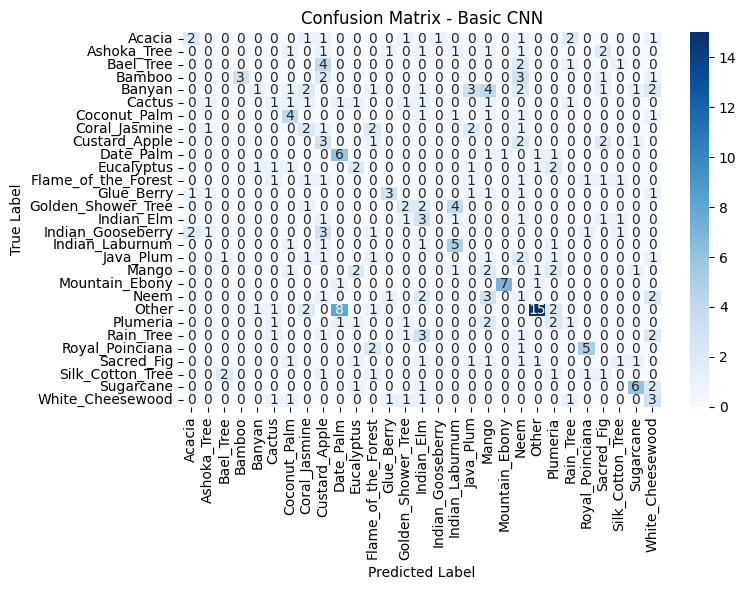

In [34]:
results_Basic_CNN= evaluate_model_basic(
    '/content/drive/MyDrive/basic_cnn_base.keras',
    'Basic CNN',
    readable,
    val_gen
)


                                      MobileNetV2 - Head-only                                       

 Evaluation Metrics:
  🔹 loss                : 1.2862
  🔹 compile_metrics     : 0.6837

 Classification Report:
                     precision    recall  f1-score   support

             Acacia       0.75      0.60      0.67        10
        Ashoka_Tree       0.60      0.33      0.43         9
          Bael_Tree       0.78      0.88      0.82         8
             Bamboo       1.00      0.60      0.75        10
             Banyan       0.62      0.68      0.65        19
             Cactus       0.75      0.60      0.67        10
       Coconut_Palm       1.00      1.00      1.00         9
      Coral_Jasmine       0.75      0.67      0.71         9
      Custard_Apple       0.42      0.56      0.48         9
          Date_Palm       0.83      1.00      0.91        10
         Eucalyptus       0.60      0.67      0.63         9
Flame_of_the_Forest       1.00      0.62      0.77   

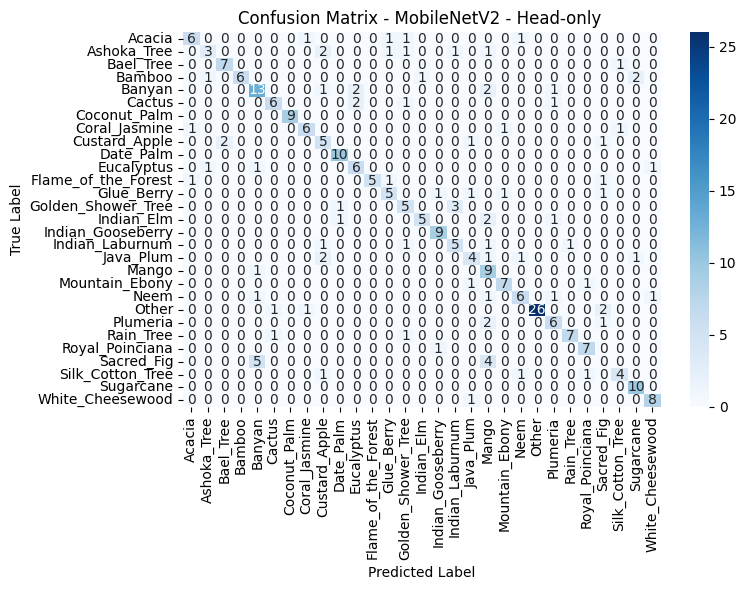

In [40]:

results_Mobnet_head = evaluate_model(
    '/content/drive/MyDrive/mobilenetv2_head.keras',
    'MobileNetV2 - Head-only ',
    val_gen,
    readable)

                                   MobileNetV2 - Fine-tuned (SGD)                                   


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 40 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 Evaluation Metrics:
  🔹 loss                : 1.1470
  🔹 compile_metrics     : 0.6973

 Classification Report:
                     precision    recall  f1-score   support

             Acacia       1.00      0.70      0.82        10
        Ashoka_Tree       0.86      0.67      0.75         9
          Bael_Tree       0.58      0.88      0.70         8
             Bamboo       1.00      0.40      0.57        10
             Banyan       0.50      0.53      0.51        19
             Cactus       1.00      0.60      0.75        10
       Coconut_Palm       0.90      1.00      0.95         9
      Coral_Jasmine       0.78      0.78      0.78         9
      Custard_Apple       0.71      0.56      0.62         9
          Date_Palm       0.77      1.00      0.87        10
         Eucalyptus       0.71      0.56      0.62         9
Flame_of_the_Forest       0.71      0.62      0.67         8
         Glue_Berry       0.75      0.67      0.71         9
 Golden_Shower_Tree       0.50  

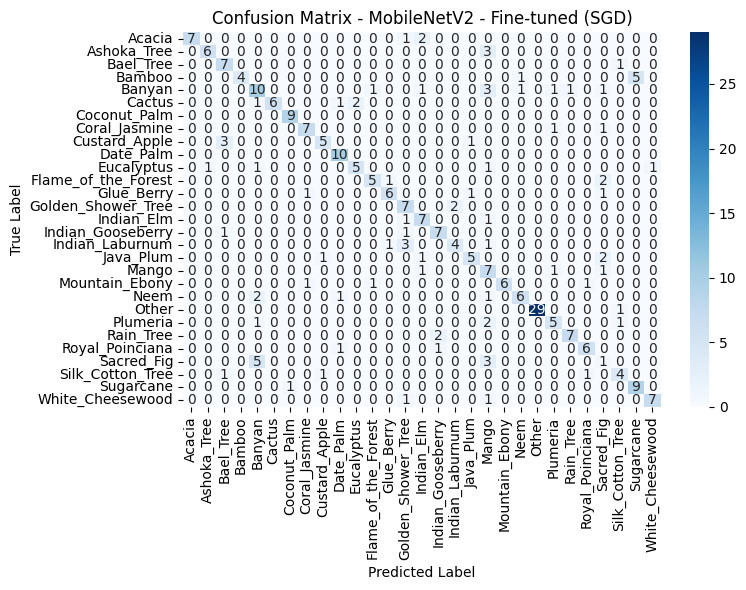

In [41]:

results_Mobnet_finetune_adamw = evaluate_model(
    '/content/drive/MyDrive/mobilenetv2_finetuned_adamw.keras',
    'MobileNetV2 - Fine-tuned (AdamW)',
    val_gen,
    readable
)


                                   MobileNetV2 - Fine-tuned (SGD)                                   


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 21 variables whereas the saved optimizer has 25 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 Evaluation Metrics:
  🔹 loss                : 1.3395
  🔹 compile_metrics     : 0.6701

 Classification Report:
                     precision    recall  f1-score   support

             Acacia       0.86      0.60      0.71        10
        Ashoka_Tree       0.38      0.33      0.35         9
          Bael_Tree       0.46      0.75      0.57         8
             Bamboo       1.00      0.50      0.67        10
             Banyan       0.64      0.47      0.55        19
             Cactus       0.78      0.70      0.74        10
       Coconut_Palm       0.89      0.89      0.89         9
      Coral_Jasmine       0.62      0.56      0.59         9
      Custard_Apple       0.60      0.67      0.63         9
          Date_Palm       0.77      1.00      0.87        10
         Eucalyptus       0.71      0.56      0.62         9
Flame_of_the_Forest       0.57      0.50      0.53         8
         Glue_Berry       0.50      0.78      0.61         9
 Golden_Shower_Tree       0.50  

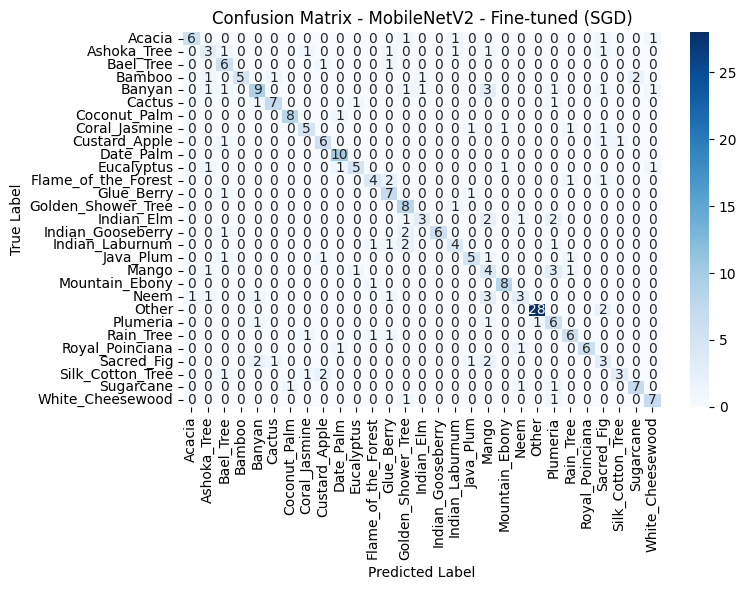

In [45]:

results_Mobnet_finetune_sgd = evaluate_model(
    '/content/drive/MyDrive/mobilenetv2_fast_finetuned.keras',
    'MobileNetV2 - Fine-tuned (SGD)',
    val_gen,
    readable
)


                                     EfficientNetV2 - head only                                     

 Evaluation Metrics:
  🔹 loss                : 1.0324
  🔹 compile_metrics     : 0.7279

 Classification Report:
                     precision    recall  f1-score   support

             Acacia       0.69      0.90      0.78        10
        Ashoka_Tree       0.80      0.44      0.57         9
          Bael_Tree       0.78      0.88      0.82         8
             Bamboo       1.00      0.70      0.82        10
             Banyan       0.47      0.47      0.47        19
             Cactus       1.00      0.60      0.75        10
       Coconut_Palm       0.82      1.00      0.90         9
      Coral_Jasmine       0.80      0.44      0.57         9
      Custard_Apple       0.73      0.89      0.80         9
          Date_Palm       0.80      0.80      0.80        10
         Eucalyptus       0.58      0.78      0.67         9
Flame_of_the_Forest       0.89      1.00      0.94   

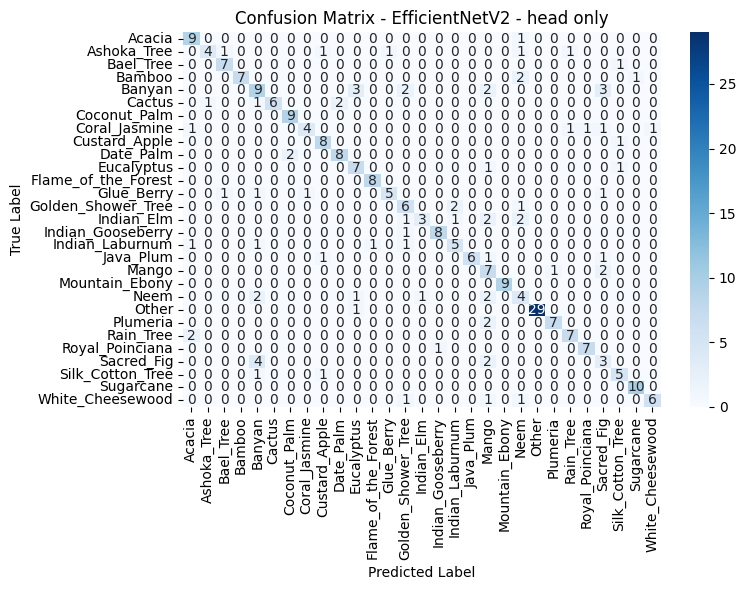

In [65]:
results_effnet_head = evaluate_effnetb0(
    '/content/drive/MyDrive/efficientnetv2_head.keras',
    'EfficientNetV2 - head only',
    val_gen_eff,
    readable
)



                                EfficientNetV2 - Fine-tuned (AdamW)                                 


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 94s 9s/step

Summary Metrics:
🔹 Accuracy        : 0.79
🔹 Macro F1        : 0.78
🔹 Weighted F1     : 0.79
🔹 Macro Precision : 0.80
🔹 Macro Recall    : 0.77



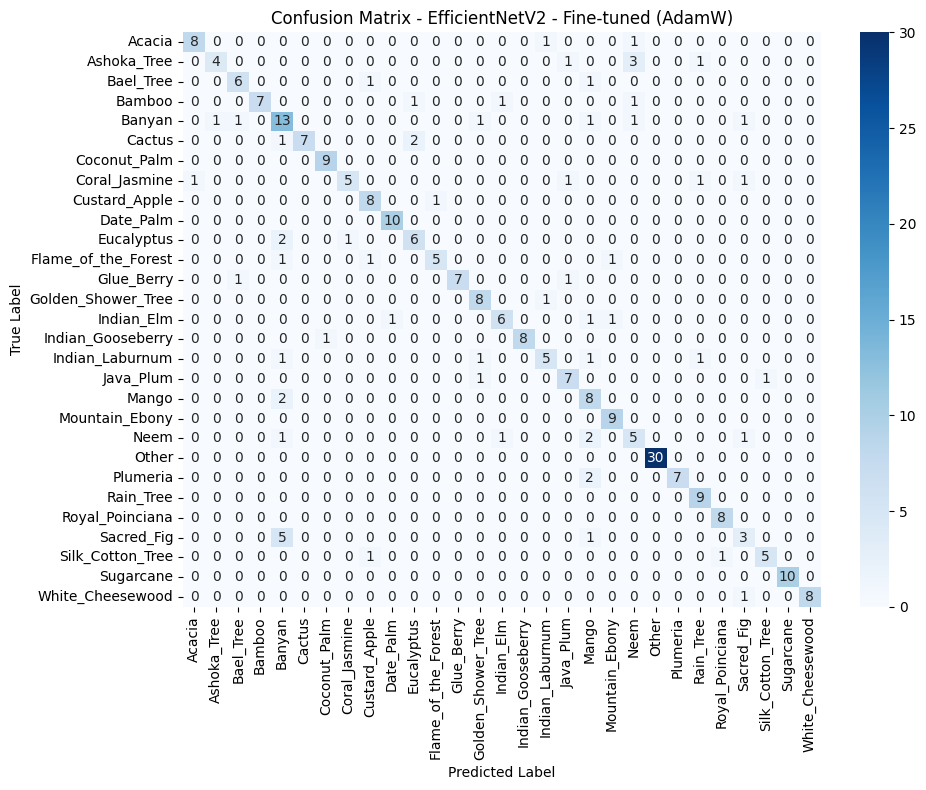

In [75]:
results_effnet_adamw = evaluate_model_effnetB0_ft(
    '/content/drive/MyDrive/effnetv2_finetuned_adamw.keras',
    'EfficientNetV2 - Fine-tuned (AdamW)',
    val_gen_eff,
    readable
)

In [76]:
# @title Model Comparison from here

all_results = [
    results_Basic_CNN,
    results_Mobnet_head,
    results_Mobnet_finetune_adamw,
    results_Mobnet_finetune_sgd,
    results_effnet_head,
    results_effnet_adamw,
]


In [77]:
# Sort by accuracy
sorted_by_accuracy = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)

# Sort by macro F1
sorted_by_macro_f1 = sorted(all_results, key=lambda x: x['macro_f1'], reverse=True)


In [79]:
print(f"{'Model':<40} {'Accuracy':<10} {'Macro F1':<10} {'Weighted F1':<13}")
print("-" * 75)
for r in sorted_by_accuracy:
    print(f"{r['name']:<40} {r['accuracy']:<10.2f} {r['macro_f1']:<10.2f} {r['weighted_f1']:<13.2f}")


Model                                    Accuracy   Macro F1   Weighted F1  
---------------------------------------------------------------------------
EfficientNetV2 - Fine-tuned (AdamW)      0.79       0.78       0.79         
EfficientNetV2 - head only               0.72       0.72       0.73         
MobileNetV2 - Head-only                  0.70       0.68       0.70         
MobileNetV2 - Fine-tuned (SGD)           0.69       0.68       0.70         
MobileNetV2 - Fine-tuned (SGD)           0.64       0.62       0.64         
Basic CNN                                0.27       0.24       0.26         


In [81]:
best_model = sorted_by_accuracy[0]  # or use sorted_by_macro_f1[0]
print(f"\n Best model: {best_model['name']} with Accuracy = {best_model['accuracy']:.2f}")



 Best model: EfficientNetV2 - Fine-tuned (AdamW) with Accuracy = 0.79


In [84]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import os

# Register custom metric
top_3_acc = TopKCategoricalAccuracy(k=3, name="top_3_acc")

# Define the correct path
best_model_path = '/content/drive/MyDrive/effnetv2_finetuned_adamw.keras'

# Load with custom objects
if os.path.exists(best_model_path):
    final_model = load_model(best_model_path, custom_objects={"TopKAccFloat32": TopKCategoricalAccuracy})
    print(" Model loaded successfully.")
else:
    print(f" File not found: {best_model_path}")


 Model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
